In [5]:
# ! pip install yfinance
import Ab as ab
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Get data from yahoo finance
sd = dt.datetime(2015,3,1)
ed = dt.datetime(2023,3,3)
# 1x leveraged nasdaq 100 etf
qqq = ab.StockData('QQQ')
qqq.get_data_from_yfinance('QQQ', sd, ed)
# 2x leveraged nasdaq 100 etf
qld = ab.StockData('QLD')
qld.get_data_from_yfinance('QLD', sd, ed)
# 3x leveraged nasdaq 100 etf
tqqq = ab.StockData('TQQQ')
tqqq.get_data_from_yfinance('TQQQ', sd, ed)
#nasdaq 100 index
ndx = ab.StockData('NDX')
ndx.get_data_from_yfinance('NDX', sd, ed)
#S&P 500 etf
spy = ab.StockData('SPY')
spy.get_data_from_yfinance('SPY', sd, ed)
#nasdaq stocks above 200 day moving average percentage
naa200r = ab.StockData('NAA200R')
naa200r.get_data_from_csv('data/NAA200R.csv')

ffty = ab.StockData('FFTY')
ffty.get_data_from_yfinance('FFTY',sd, ed)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
def ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, spy_consecutive_buy_threshold = 1, spy_consecutive_days = 10, spy_max_off_new_high_pct = -0.2):
    
    ## ffty signals
    ffty.get_indicators()
    ffty.get_thresholds()
    ffty_signals_df = ffty.data.copy()
    ffty_signals_df['Signal'] = np.where(ffty_signals_df['price_to_MA200'] > ffty_buy_threshold, 1.0, 0.0)
    ffty_signals_df['Signal'] = np.where(ffty_signals_df['price_to_MA200'] < ffty_sell_threshold, -1, ffty_signals_df['Signal'])
    ffty_signals_df = ffty_signals_df[['Signal']]

    ## spy signals
    spy.get_indicators()
    spy.get_thresholds()
    spy.data['new_high'] = spy.data['Close'].cummax()
    spy.data['off_new_high'] = spy.data['Close'] / spy.data['new_high'] - 1
    spy.data['max_off_new_high'] = spy.data['off_new_high'].rolling(252,min_periods=1).min()
    spy.data['Close_prev'] = spy.data['Close'].shift(spy_consecutive_days)
    spy.data['price_to_MA200_prev'] = spy.data['price_to_MA200'].shift(spy_consecutive_days)

    spy_signals_df = spy.data.copy()
    # buy rule: two consecutive weeks of above 200 AND previously SPY DOWN 20%
    buy_rule = (spy_signals_df['max_off_new_high']< spy_max_off_new_high_pct ) & (spy_signals_df['price_to_MA200'] > spy_consecutive_buy_threshold) & (spy_signals_df['price_to_MA200_prev'] >  spy_consecutive_buy_threshold)
    #fill in the first 10 days with 0
    buy_rule.iloc[0:spy_consecutive_days] = False
    spy_signals_df['Signal'] = np.where(buy_rule, 1, 0)
    spy_signals_df = spy_signals_df[['Signal']]

    signals_df = ffty_signals_df.rename(columns={'Signal':'FFTY_Signal'}).join(spy_signals_df.rename(columns={'Signal':'SPY_Signal'}), how='outer')
    signals_df['FFTY_Signal'] = signals_df['FFTY_Signal'].fillna(0)
    signals_df['Signal']= np.where((signals_df['SPY_Signal']==1)|(signals_df['FFTY_Signal']==1), 1, np.where(signals_df['FFTY_Signal']==-1, -1, 0))

    return signals_df


ticker = qld

In [7]:
#buy and hold strategy vs various  strategies
def backtestAll(ticker:ab.StockData,test_start:dt.datetime,test_end:dt.datetime, weekly_trading = False, verbose = True):
    perf_summary = pd.DataFrame()
    buy_and_hold = ab.BuyAndHold() 
    buy_and_hold.run_strategy(ticker, test_start,test_end)
    bt = ab.BackTest()
    bt.run_backtest(buy_and_hold, ticker, test_start, test_end, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # macross_strategy = ab.MACross('Ma Cross',50, 200)
    # macross_strategy.run_strategy(ticker, test_start ,test_end)
    # ma_cross_bt = ab.BackTest()
    # ma_cross_bt.run_backtest(macross_strategy, ticker)#, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    threshold_strategy = ab.Threshold(name='NAA200R',buy_threshold = 15, sell_threshold = 30)
    threshold_strategy.run_strategy(naa200r, test_start , test_end)
    naa200r_threshold_bt = ab.BackTest()
    naa200r_threshold_bt.run_backtest(threshold_strategy, ticker, test_start , test_end, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # ma_threshold = ab.MAThreshold('SMA200', ma_window = 200,buy_threshold = 1.05, sell_threshold = 0.95)
    # ma_threshold.run_strategy(ticker, test_start,test_end)
    # ma_threshold_bt = ab.BackTest()
    # ma_threshold_bt.run_backtest(ma_threshold, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    # ma_threshold2 = ab.MAThreshold('SMA200', ma_window = 200,buy_threshold = 1.03, sell_threshold = 0.95)
    # ma_threshold2.run_strategy(ticker, test_start,test_end)
    # ma_threshold2_bt = ab.BackTest()
    # ma_threshold2_bt.run_backtest(ma_threshold2, ticker, weekly_buy = weekly_trading, weekly_sell = weekly_trading)
    
    #WeeklyMAThreshold = ab.WeeklyMAThreshold('2W SMA200', ma_window =40,buy_threshold=1,sell_threshold=1)
    #WeeklyMAThreshold.run_strategy(ticker, test_start , test_end)
    #WeeklyMAThreshold_bt = ab.BackTest()
    #WeeklyMAThreshold_bt.run_backtest(WeeklyMAThreshold, ticker, test_start , test_end, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    signals_df = ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                            spy_max_off_new_high_pct = -0.2)
    fftystrategy = ab.CustomizedStrategy(signals_df = signals_df)
    fftystrategy.run_strategy(ticker, test_start,test_end)
    fftystrategy_bt = ab.BackTest()
    fftystrategy_bt.run_backtest(fftystrategy, ticker, test_start, test_end, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    signals_df = ffty_and_spy_strategy_signal(sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 20,
                                            spy_max_off_new_high_pct = -0.2)
    fftystrategy_month = ab.CustomizedStrategy(signals_df = signals_df)
    fftystrategy_month.run_strategy(ticker, test_start,test_end)
    fftystrategy_bt_month = ab.BackTest()
    fftystrategy_bt_month.run_backtest(fftystrategy_month, ticker, test_start , test_end, weekly_buy = weekly_trading, weekly_sell = weekly_trading)

    print('Backtest for', ticker.ticker)
    bt.performance_summary(v = verbose)
    # ma_cross_bt.performance_summary(v = verbose)
    naa200r_threshold_bt.performance_summary(v = verbose)
    # ma_threshold_bt.performance_summary(v = verbose)
    # ma_threshold2_bt.performance_summary(v = verbose)
    #WeeklyMAThreshold_bt.performance_summary(v = verbose)
    fftystrategy_bt.performance_summary(v = verbose)
    fftystrategy_bt_month.performance_summary(v = verbose)

    fig = plt.figure(figsize=(16,4))
    plt.plot(bt.balance.index, bt.balance['Total'], label = bt.name)
    # plt.plot(ma_cross_bt.balance['Date'], ma_cross_bt.balance['Total'], label = ma_cross_bt.name)
    plt.plot(naa200r_threshold_bt.balance.index, naa200r_threshold_bt.balance['Total'], label = naa200r_threshold_bt.name)
    # plt.plot(ma_threshold_bt.balance['Date'], ma_threshold_bt.balance['Total'], label = ma_threshold_bt.name)
    # plt.plot(ma_threshold2_bt.balance['Date'], ma_threshold2_bt.balance['Total'], label = ma_threshold2_bt.name)
    #plt.plot(WeeklyMAThreshold_bt.balance['Date'], WeeklyMAThreshold_bt.balance['Total'], label = WeeklyMAThreshold_bt.name)
    plt.plot(fftystrategy_bt.balance.index, fftystrategy_bt.balance['Total'], label = 'FFTY_SPY_Strategy 2w above')
    plt.plot(fftystrategy_bt_month.balance.index, fftystrategy_bt_month.balance['Total'], label = 'FFTY_SPY_Strategy 2m above')

    plt.legend()
    plt.title('Backtesting for {}'.format(ticker.ticker))
    plt.show()


    for strategy in [bt,
    # ma_cross_bt,
    naa200r_threshold_bt, 
    # ma_threshold_bt, 
    # ma_threshold2_bt, 
    #WeeklyMAThreshold_bt, 
    fftystrategy_bt,
    fftystrategy_bt_month]:
        perf_summary = pd.concat([perf_summary, strategy.summary_result])
        
    return perf_summary

/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


Backtest for QQQ


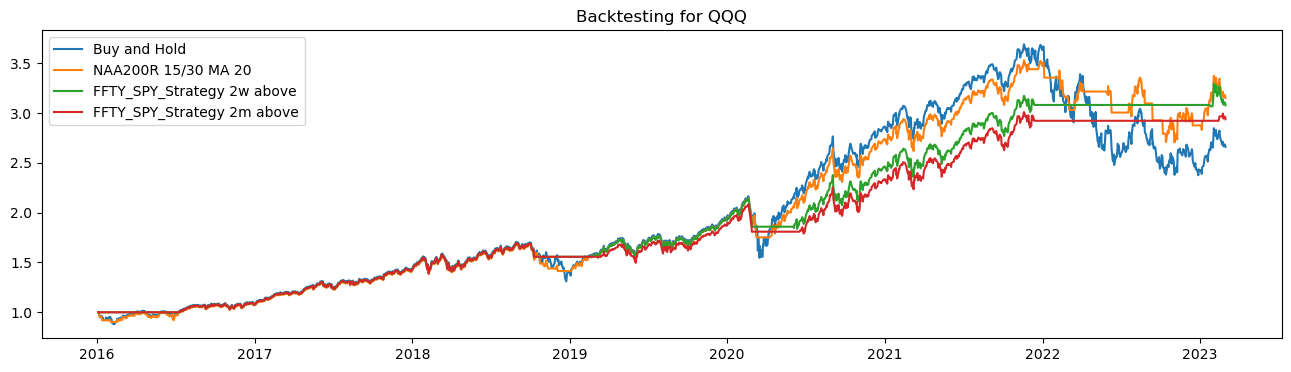

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,1.659361,0.051948,-0.355207,0.044377,0.000651,0.014677,2613,1.000000,1.659361,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,20,2.150706,0.079588,-0.233286,0.061185,0.000704,0.011502,2613,0.368421,0.295664,-0.036859,8.021473,0.367487,0.017419
0,Customized,6,2.077158,0.075838,-0.142036,0.074396,0.000664,0.008929,2613,0.800000,0.352815,-0.004257,82.886961,0.306518,NaN
0,Customized,6,1.937161,0.068357,-0.141645,0.073534,0.000636,0.008648,2613,0.800000,0.337255,-0.009625,35.040135,0.294458,NaN


In [8]:
test_start,test_end = dt.datetime(2016,1,1), dt.datetime(2023,3,1)

perf_summary = backtestAll(qqq, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


Backtest for QLD


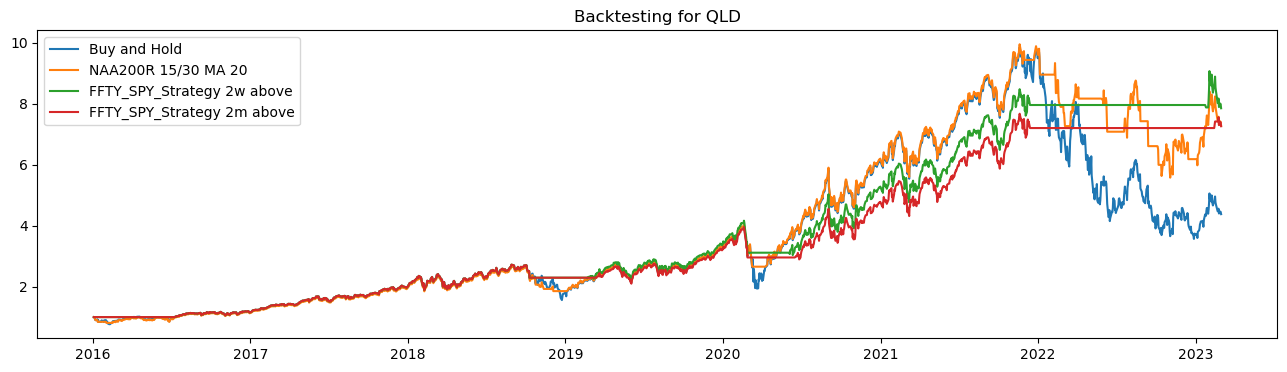

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,3.374484,0.129330,-0.631892,0.042753,0.001255,0.029355,2613,1.000000,3.374484,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,20,6.271678,0.201540,-0.439676,0.059605,0.001367,0.022938,2613,0.368421,0.701827,-0.074434,9.428809,0.974692,0.034875
0,Customized,6,6.845497,0.212106,-0.271226,0.073269,0.001304,0.017800,2613,0.600000,1.068398,-0.006701,159.427590,0.629653,0.004672
0,Customized,6,6.256295,0.201245,-0.268498,0.072584,0.001251,0.017231,2613,0.800000,0.761618,-0.020982,36.298149,0.705575,NaN


In [9]:
perf_summary = backtestAll(qld, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

In [10]:
test_start,test_end = dt.datetime(2016,1,1), dt.datetime(2023,3,1)
perf_summary = pd.DataFrame()
buy_and_hold = ab.BuyAndHold() 
buy_and_hold.run_strategy(ticker, test_start,test_end)
bt = ab.BackTest()
bt.run_backtest(buy_and_hold, ticker, test_start, test_end, weekly_buy = True, weekly_sell = False)

/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


In [11]:
bt.trade_records

,Buy Date,Sell Date,Ticker,Quant,Buy Price,Sell Price,Profit,Profit %
0,2016-01-04,2023-03-01 00:00:00,QLD,0.106539,9.38625,41.060001,3.374484,3.374484


/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


Backtest for TQQQ


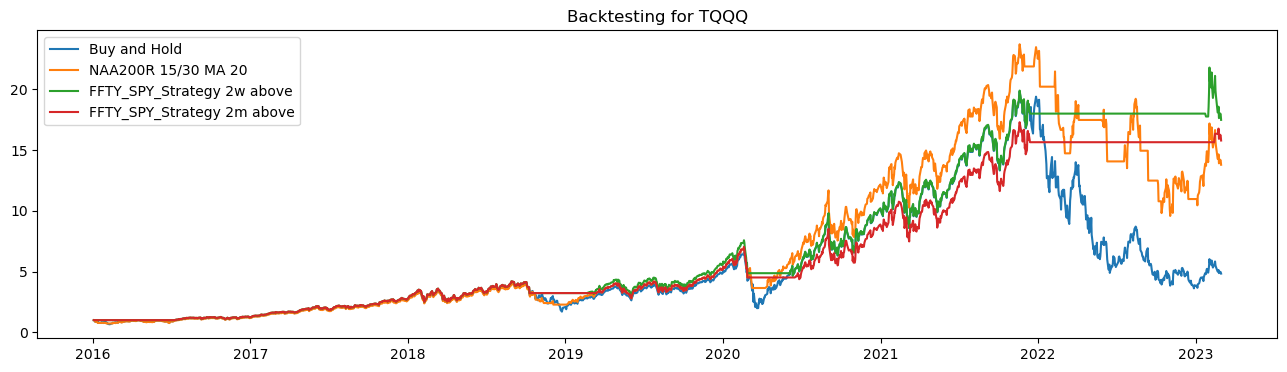

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,3.831329,0.143760,-0.811138,0.042260,0.001832,0.043355,2613,1.000000,3.831329,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,20,12.794813,0.290338,-0.596052,0.060028,0.002047,0.034097,2613,0.368421,1.261003,-0.110512,11.410601,1.899832,0.051835
0,Customized,6,16.490497,0.323498,-0.384623,0.073437,0.001946,0.026502,2613,0.600000,1.811872,-0.014425,125.608829,1.153990,0.001526
0,Customized,6,14.791718,0.309188,-0.378281,0.072746,0.001867,0.025667,2613,0.800000,1.284555,-0.034004,37.776033,1.239952,NaN


In [12]:
perf_summary = backtestAll(tqqq, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

/home/zishuowang/backtesting/Ab.py:161: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  sd = indicator.data.index[indicator.data.index.get_loc(


Backtest for SPY


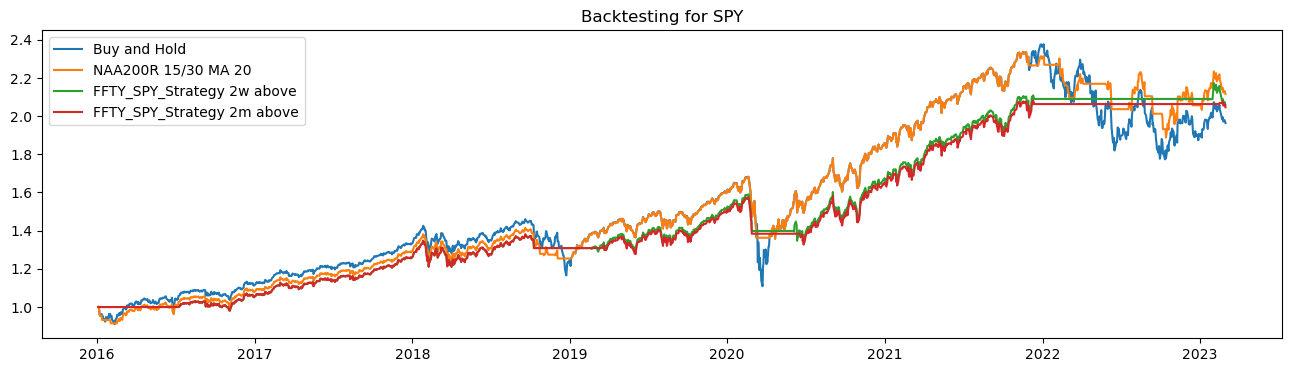

,name,num_trades,cumulative_return,annual_return,max_drawdown,sharp_ratio,avg_daily_return,std_daily_return,num_trading_days,Betting Average,Gain Average,Loss Average,Risk Reward Ratio,Gain STD,Loss STD
0,Buy and Hold,2,0.963685,-0.003692,-0.341047,0.037274,0.000447,0.011993,2613,1.000000,0.963685,NaN,NaN,NaN,NaN
0,NAA200R 15/30 MA 20,20,1.115612,0.011000,-0.192412,0.051042,0.000456,0.008940,2613,0.421053,0.163797,-0.030001,5.459792,0.238292,0.018107
0,Customized,6,1.058182,0.005671,-0.154844,0.062985,0.000424,0.006725,2613,0.600000,0.290627,-0.007651,37.984596,0.213551,0.009832
0,Customized,6,1.046418,0.004548,-0.156951,0.065119,0.000418,0.006425,2613,0.800000,0.214953,-0.010900,19.720832,0.227094,NaN


In [13]:
perf_summary = backtestAll(spy, test_start, test_end, weekly_trading = False, verbose = False)
display(perf_summary)

In [14]:
def ffty_spy_performance(ticker, sd, ed, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                         spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                         spy_max_off_new_high_pct = -0.2, signal_ma_window = 200,
                                           visualization=True):
    

    ticker_data = ticker.data.sort_index().loc[sd:ed].copy()
    ticker_name = ticker.ticker

    ffty = ab.StockData('FFTY')
    ffty.get_data_from_yfinance('FFTY', sd, ed)
    ffty.get_indicators()
    ffty_data = ffty.data.sort_index().loc[sd:ed].copy()

    spy = ab.StockData('SPY')
    spy.get_data_from_yfinance('SPY', sd, ed)
    spy.get_indicators()
    spy_data = spy.data.sort_index().loc[sd:ed].copy()

    signals_df = ffty_and_spy_strategy_signal(dt.datetime(1998,12,4), dt.datetime.today(), ffty_sell_threshold, ffty_buy_threshold, 
                                         spy_consecutive_buy_threshold, spy_consecutive_days,  spy_max_off_new_high_pct)
    
    mystrategy = ab.CustomizedStrategy(signals_df = signals_df)
    mystrategy.run_strategy(ticker, test_start,test_end)
    mystrategy_bt = ab.BackTest()
    mystrategy_bt.run_backtest(mystrategy, ticker,test_start, test_end)
    print(mystrategy_bt.performance_summary('FFTY+SPY'))

    if visualization == True:
        
        # get trade list

        df_balance = mystrategy_bt.balance
        df_balance['Trade'] = np.where(df_balance['Stock'].diff()>0, 1, np.where(df_balance['Stock'].diff()<0, -1, 0))

        # plots
        fig = plt.figure(figsize=(16,4))
        ffty_data['Close'].plot(label='FFTY')
        ffty_data['MA'+str(signal_ma_window)].plot(label='FFTY MA{}'.format(signal_ma_window))

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=idx, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=idx, color = 'green', linestyle='dashed') 

        # plt.ylim([0, 50])
        plt.title('Trading Signals And FFTY')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        spy_data['Close'].plot(label='SPY')
        spy_data['MA'+str(signal_ma_window)].plot(label='SPY MA{}'.format(signal_ma_window))

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=idx, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=idx, color = 'green', linestyle='dashed') 

        # plt.ylim([0, 50])
        plt.title('Trading Signals And SPY')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        ticker_data['Close'].plot()

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=idx, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=idx, color = 'green', linestyle='dashed') 
        plt.title('Trading Signals And {}'.format(ticker_name))
        plt.show()

        fig = plt.figure(figsize=(16,4))
        df_balance.plot(y = 'Total', title = 'Portfolio Performance of {}'.format(ticker_name), figsize=(16,4))
    


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Customized: 
cumulative return      : 193.72%
compound anual return  : 6.8357% 
max_drawdown           : -14.16%
sharp_ratio            : 7.35%
average of daily return: 0.0636%
std of daily return    : 0.8648%
number of trades       : 6,
trading days           : 2613,
Betting Average        : 80.00%
Gain Average           : 33.73%
Loss Average           : -0.96%
Risk Reward Ratio      : 35.04
Gain STD               : 29.45%
Loss STD               : nan%
        
None


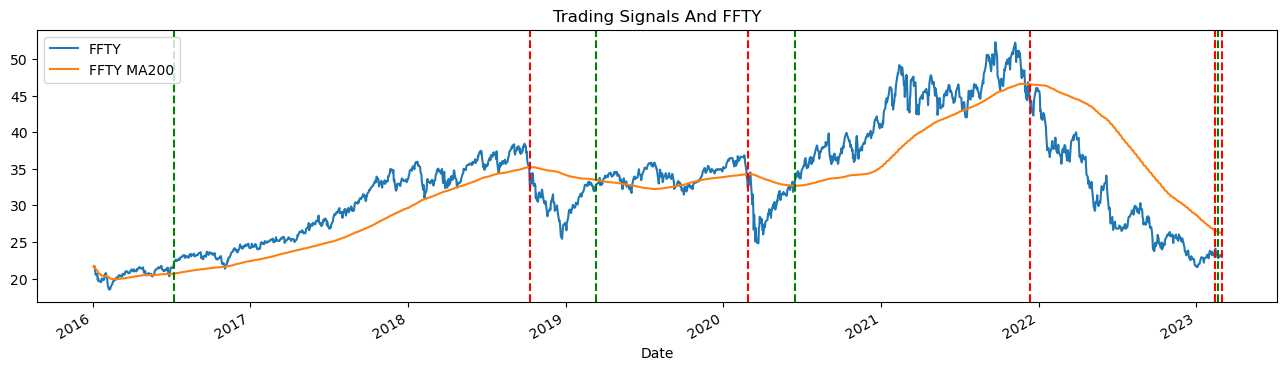

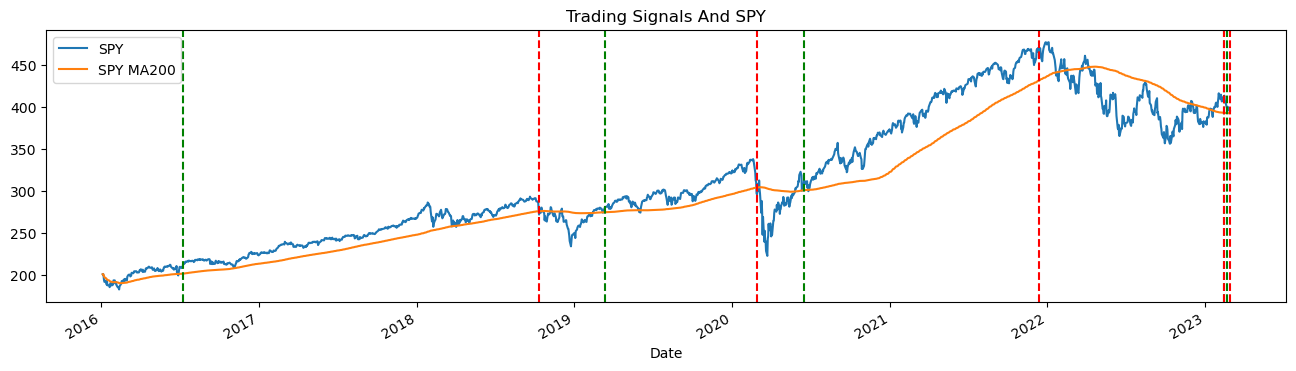

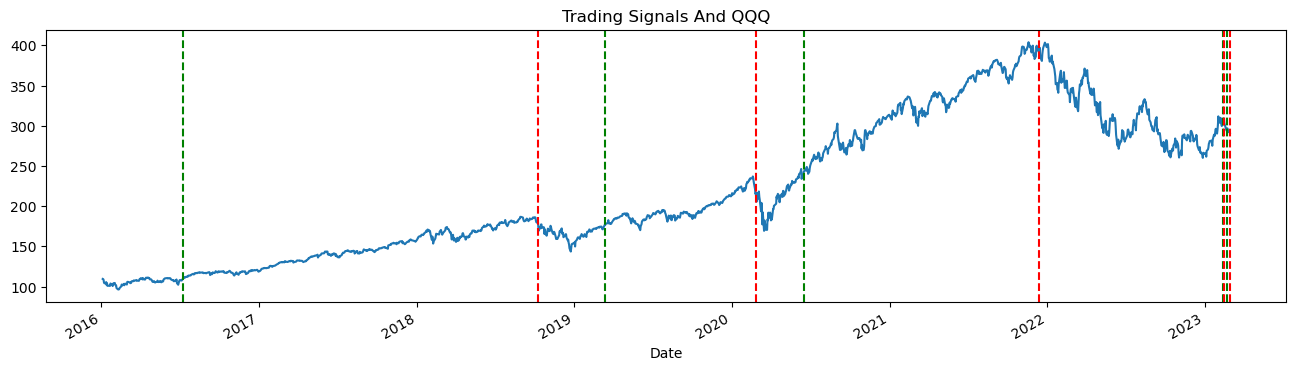

<Figure size 1600x400 with 0 Axes>

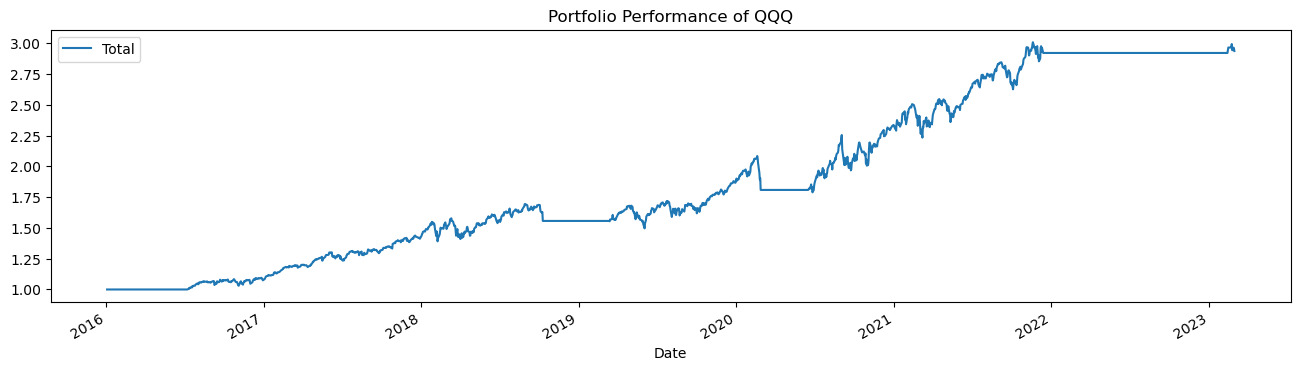

In [15]:
ffty_spy_performance(qqq, test_start, test_end, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 20,
                                            spy_max_off_new_high_pct = -0.2,
                                           visualization=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Customized: 
cumulative return      : 207.72%
compound anual return  : 7.5838% 
max_drawdown           : -14.20%
sharp_ratio            : 7.44%
average of daily return: 0.0664%
std of daily return    : 0.8929%
number of trades       : 6,
trading days           : 2613,
Betting Average        : 80.00%
Gain Average           : 35.28%
Loss Average           : -0.43%
Risk Reward Ratio      : 82.89
Gain STD               : 30.65%
Loss STD               : nan%
        
None


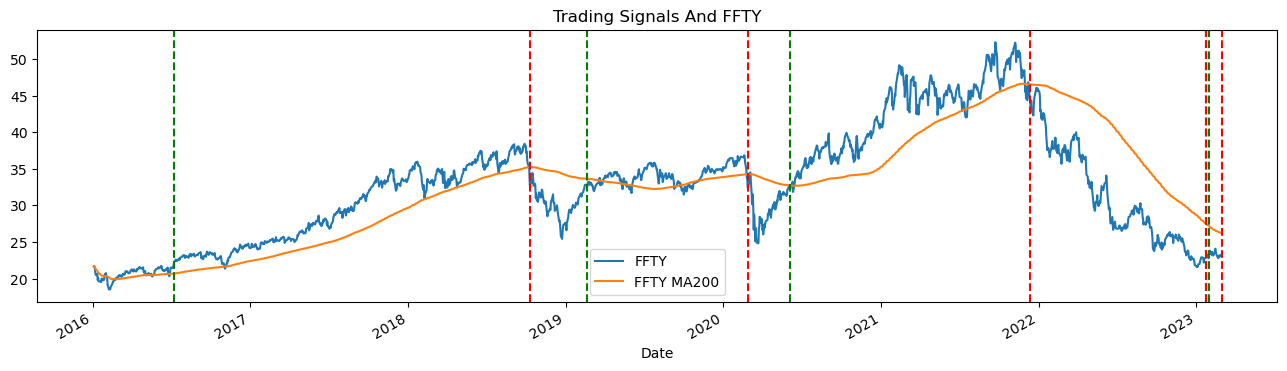

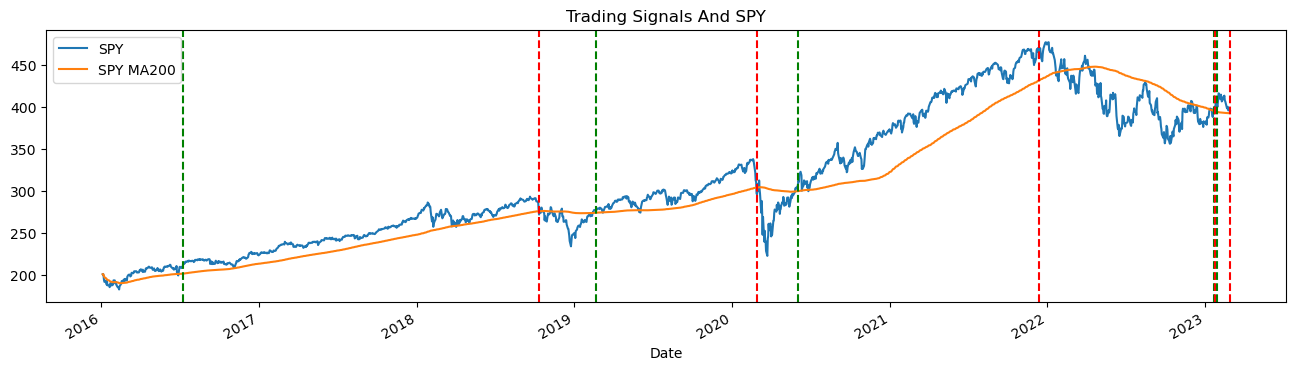

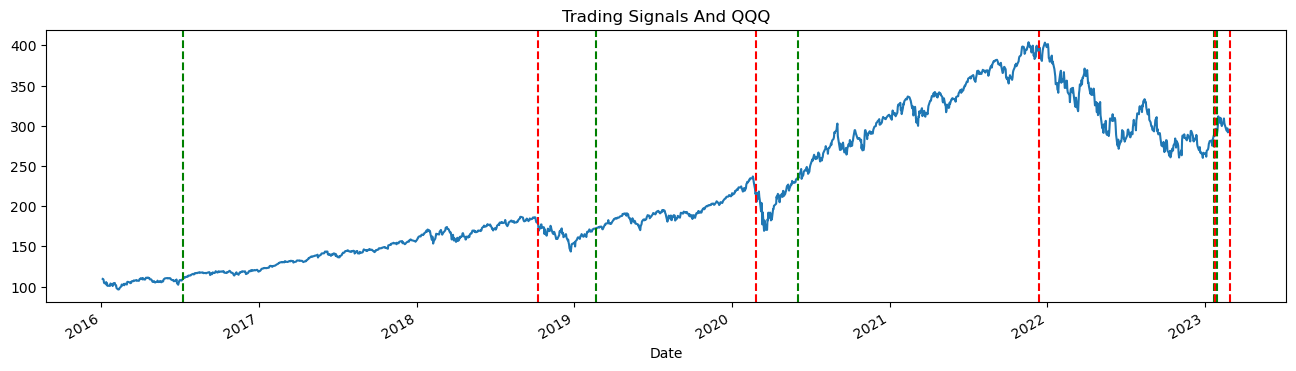

<Figure size 1600x400 with 0 Axes>

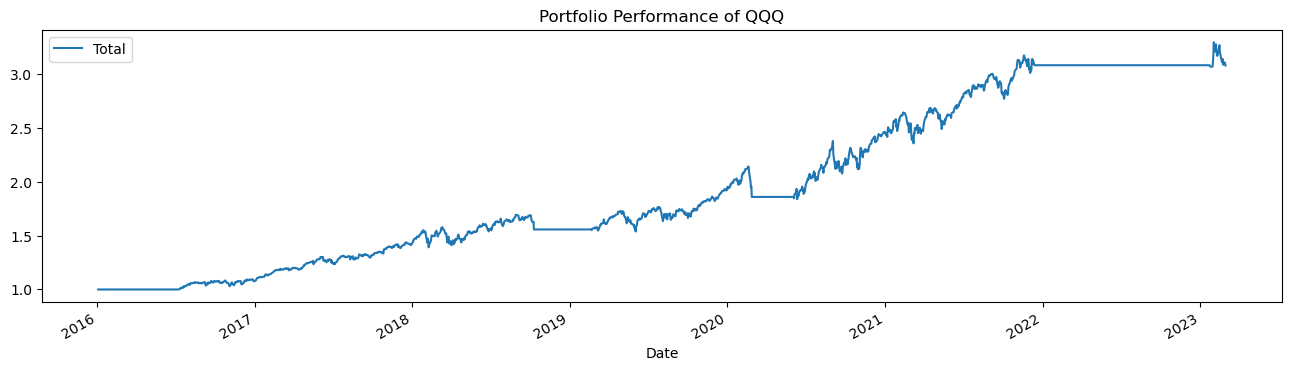

In [16]:
ffty_spy_performance(qqq, test_start, test_end, ffty_sell_threshold = 0.95, ffty_buy_threshold = 1.02, 
                                            spy_consecutive_buy_threshold = 1, spy_consecutive_days = 5,
                                            spy_max_off_new_high_pct = -0.2,
                                           visualization=True)

In [17]:
def naa200r_performance(ticker, sd, ed, signal_ma_window = 20, buy_threshold = 15 , sell_threshold = 30,  weekly_trading = True, visualization=True):
    
    signal_data = naa200r.data.sort_index().loc[sd:ed].copy()
    ticker_data = ticker.data.sort_index().loc[sd:ed].copy()
    ticker_name = ticker.ticker
    
    threshold_strategy = ab.Threshold(
                                    buy_threshold = buy_threshold , sell_threshold = sell_threshold , 
                                    signal_ma_window=signal_ma_window )

    # run strategy
    threshold_strategy.run_strategy(naa200r, sd , ed)
    naa200r_threshold_bt = ab.BackTest()
    naa200r_threshold_bt.run_backtest(threshold_strategy, ticker, sd, ed, weekly_buy = weekly_trading, weekly_sell=weekly_trading)
    print(naa200r_threshold_bt.performance_summary('{}: NAA200R (buy {}, sell {}, MA{})'.format(ticker_name, 
                                                                                         buy_threshold, sell_threshold, signal_ma_window)))


    if visualization == True:
        
        # get trade list
        df_balance = naa200r_threshold_bt.balance
        df_balance['Trade'] = np.where(df_balance['Stock'].diff()>0, 1, np.where(df_balance['Stock'].diff()<0, -1, 0))

        # plots
        fig = plt.figure(figsize=(16,4))
        signal_data['Close'].plot(label='NAA200R')
        signal_data['Close'].rolling(signal_ma_window,min_periods=1).mean().plot(label='NAA200R MA{}'.format(signal_ma_window))


        plt.axhline(y = 15, color = 'black', linestyle='dashed') 
        plt.axhline(y = 30, color = 'black', linestyle='dashed') 

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=idx, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=idx, color = 'green', linestyle='dashed') 

        plt.ylim([0, 50])
        plt.title('Trading Signals And NAA200R')
        plt.legend()
        plt.show()

        fig = plt.figure(figsize=(16,4))
        ticker_data['Close'].plot()

        trades = df_balance.loc[df_balance['Trade']!=0]
        for idx, row in trades.iterrows():
            if row['Trade']<0:
                plt.axvline(x=idx, color = 'red', linestyle='dashed') 
            if row['Trade']>0:
                plt.axvline(x=idx, color = 'green', linestyle='dashed') 
        plt.title('Trading Signals And {}'.format(ticker_name))
        plt.show()

        fig = plt.figure(figsize=(16,4))
        df_balance.plot(y = 'Total', title = 'Portfolio Performance of {}'.format(ticker_name), figsize=(16,4))


TH 15/30 MA 20: 
cumulative return      : 215.07%
compound anual return  : 7.9588% 
max_drawdown           : -23.33%
sharp_ratio            : 6.12%
average of daily return: 0.0704%
std of daily return    : 1.1502%
number of trades       : 20,
trading days           : 2613,
Betting Average        : 36.84%
Gain Average           : 29.57%
Loss Average           : -3.69%
Risk Reward Ratio      : 8.02
Gain STD               : 36.75%
Loss STD               : 1.74%
        
None


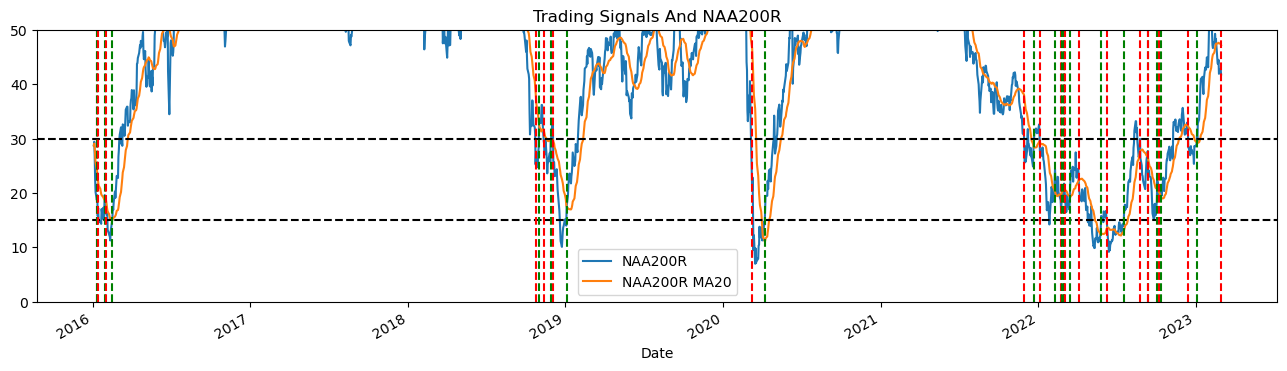

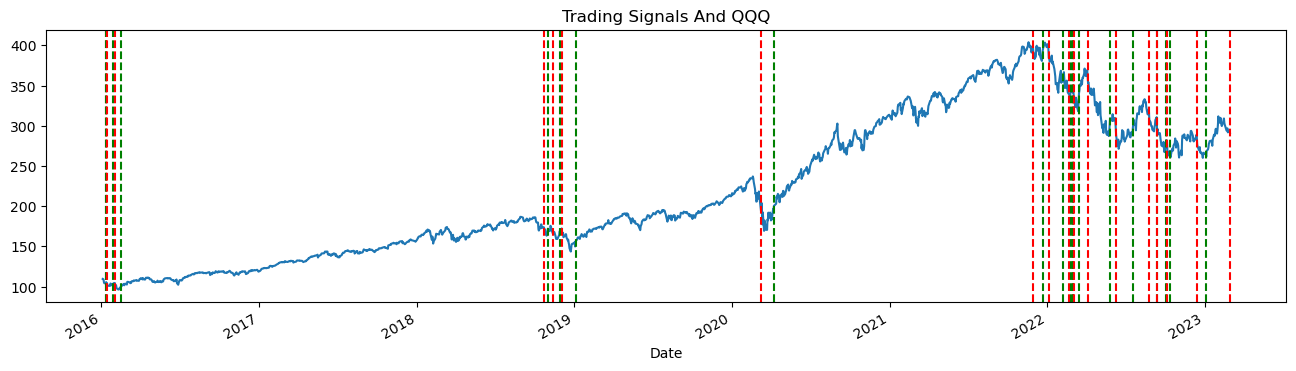

<Figure size 1600x400 with 0 Axes>

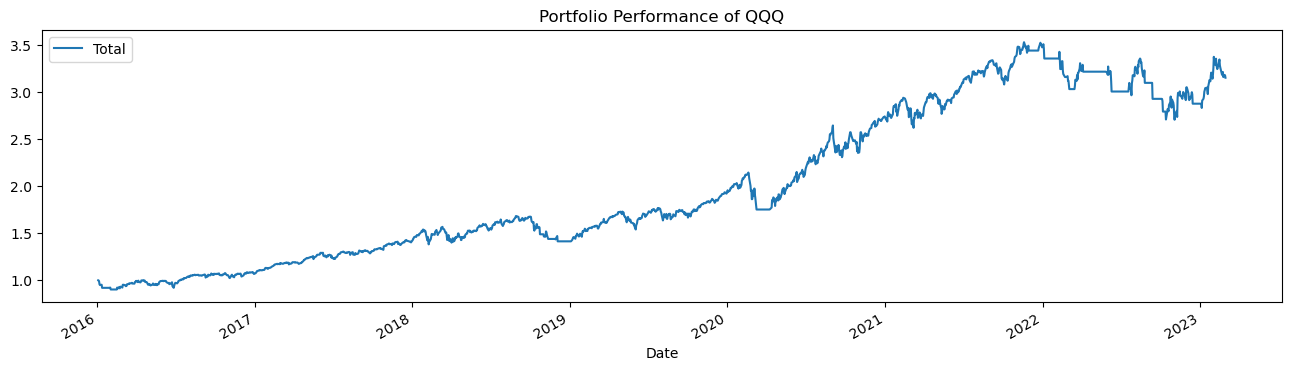

In [18]:
signal_ma_window = 20
buy_threshold = 15
sell_threshold = 30
ticker = qqq

naa200r_performance(qqq, test_start, test_end, signal_ma_window, buy_threshold , sell_threshold,  weekly_trading = True, visualization=True)


TH 15/30 MA 20: 
cumulative return      : 215.07%
compound anual return  : 7.9588% 
max_drawdown           : -23.33%
sharp_ratio            : 6.12%
average of daily return: 0.0704%
std of daily return    : 1.1502%
number of trades       : 20,
trading days           : 2613,
Betting Average        : 36.84%
Gain Average           : 29.57%
Loss Average           : -3.69%
Risk Reward Ratio      : 8.02
Gain STD               : 36.75%
Loss STD               : 1.74%
        
None


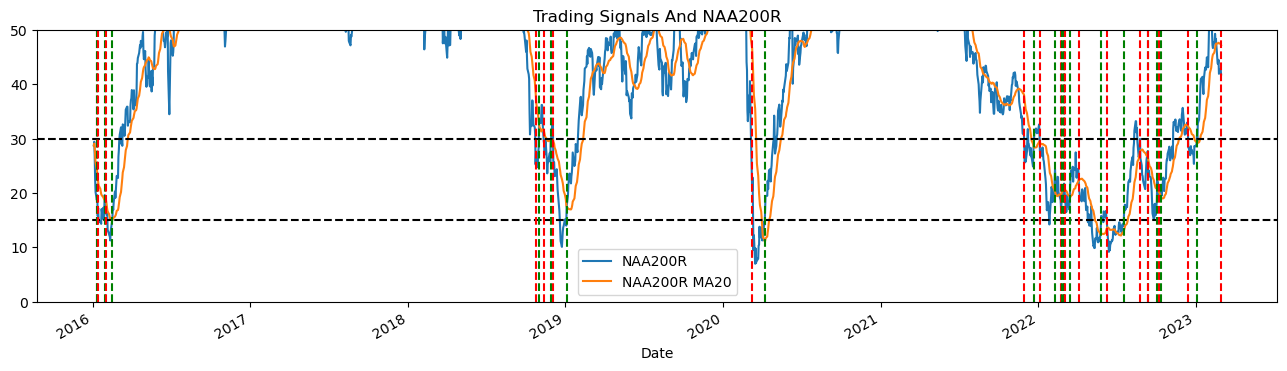

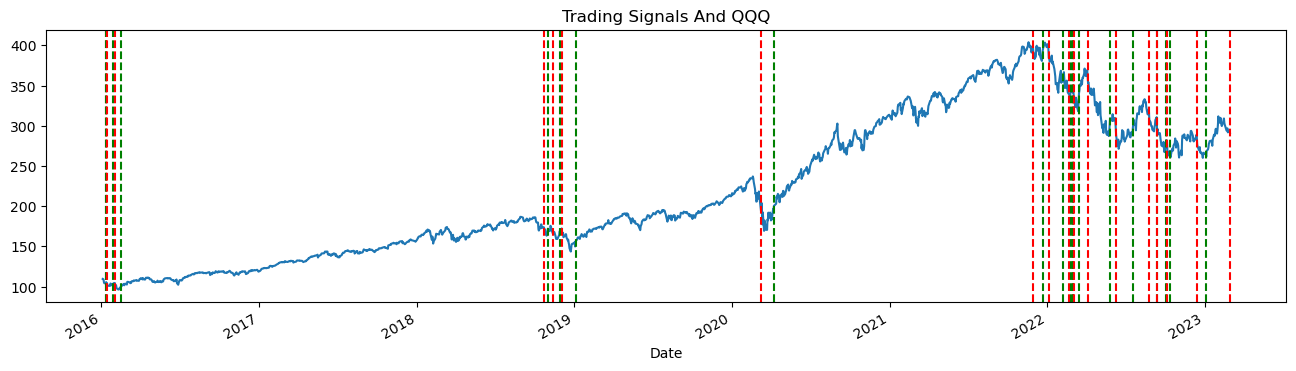

<Figure size 1600x400 with 0 Axes>

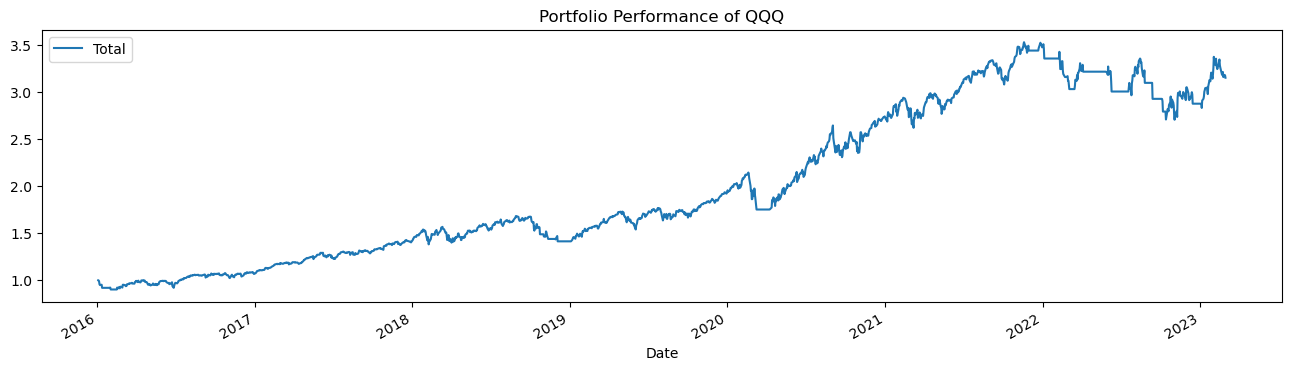

In [19]:
naa200r_performance(qqq, test_start, test_end, signal_ma_window, buy_threshold , sell_threshold,  weekly_trading = False, visualization=True)